<a href="https://colab.research.google.com/github/tejas-shanthraj/srh-da3-deep-learning/blob/main/08_Animal_Classification_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal Classification

In [2]:
!wget https://storage.googleapis.com/adsa-data/animal-classification/animal.zip
!unzip animal.zip -d temp

--2024-12-06 22:05:12--  https://storage.googleapis.com/adsa-data/animal-classification/animal.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 570445498 (544M) [application/zip]
Saving to: ‘animal.zip.1’

animal.zip.1        100%[===================>] 544.02M  25.2MB/s    in 23s     

2024-12-06 22:05:37 (23.3 MB/s) - ‘animal.zip.1’ saved [570445498/570445498]

Archive:  animal.zip
replace temp/train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: temp/train/cat.0.jpg    
replace temp/train/cat.1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:

!mkdir -p data/dog
!mkdir -p data/cat
!cp temp/train/dog.* data/dog/
!cp temp/train/cat.* data/cat/

In [4]:
import os

dog_count = len(os.listdir("./data/dog"))
cat_count = len(os.listdir("./data/cat"))
print("Dog pictures: ", dog_count)
print("Cat pictures: ", cat_count)

Dog pictures:  12500
Cat pictures:  12500


## Data Preparation

In [5]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=32

In [6]:
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [7]:
# TODO: Split and load datasets

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data',
    batch_size = batch_size,
    image_size = IMAGE_SIZE,
    seed = 42,
    validation_split = 0.2,
    subset = 'training',
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data',
    batch_size = batch_size,
    image_size = IMAGE_SIZE,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation',
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


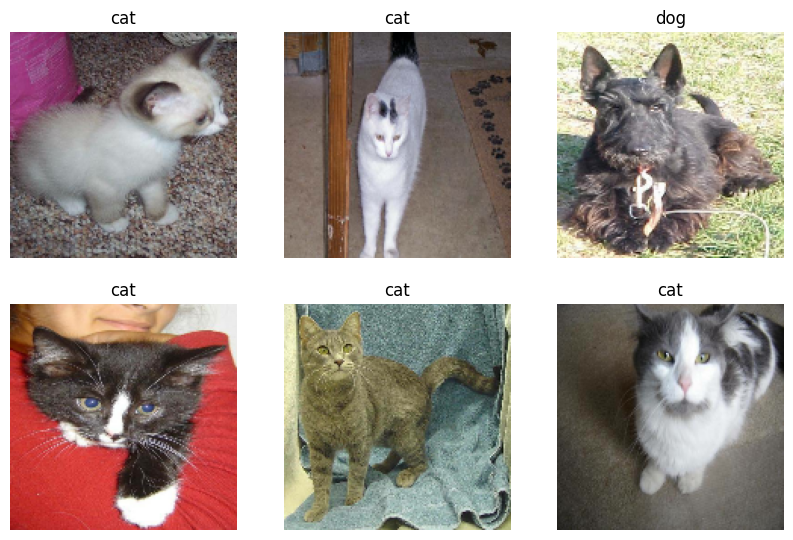

In [10]:
# TODO: Plot some images along with their labels
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
# TODO: Set cache for datasets
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Preparation

In [12]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.Sequential()

# TODO: Load EfficientNetB7 model with pretrained weights
# but without the fully-connected layer at the top.
# We want to add our own FC layers and outputs
base = tf.keras.applications.EfficientNetB7(
    include_top = False,
    input_shape = IMAGE_SIZE + (3,)
)
model.add(base)

# TODO: Add a GlobalAveragePooling2D layer
model.add(tf.keras.layers.GlobalAveragePooling2D())

# TODO: Add a Dropout layer
model.add(tf.keras.layers.Dropout(0.5))


# TODO: Add outputs
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# Allow model's weights to be updated
model.trainable = True

# TODO: Freeze base layers (Don't allow weights of the base to be updated)
base.trainable = False

for layer in model.layers:
    print(layer.name, ' ', layer.trainable)

# TODO: Add the loss function based on your outputs
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

efficientnetb7   False
global_average_pooling2d   True
dropout   True
dense   True


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 5, 5, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           5,122 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,102,809 (244.53 MB)

 Trainable params: 5,122 (20.01 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

## Training

In [13]:
# TODO: Train model for 1 epoch
epochs = 1

train = model.fit(train_ds, epochs=epochs, validation_data=val_ds,verbose=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 220s 234ms/step - accuracy: 0.9391 - loss: 0.1567 - val_accuracy: 0.9732 - val_loss: 0.0684


In [14]:
print("Training complete. Final results:")
print("Training Loss: ", train.history['loss'][-1])
print("Training Accuracy: ", train.history['accuracy'][-1])
print("Validation Loss: ", train.history['val_loss'][-1])
print("Validation Accuracy: ", train.history['val_accuracy'][-1])

Training complete. Final results:
Training Loss:  0.10923352092504501
Training Accuracy:  0.9585000276565552
Validation Loss:  0.0684112161397934
Validation Accuracy:  0.9732000231742859


## Testing

In [15]:
# TODO: Load test set
!wget https://storage.googleapis.com/adsa-data/animal-classification/test.zip
!unzip test.zip

--2024-12-06 22:10:17--  https://storage.googleapis.com/adsa-data/animal-classification/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370194 (362K) [application/zip]
Saving to: ‘test.zip.1’

test.zip.1          100%[===================>] 361.52K   567KB/s    in 0.6s    

2024-12-06 22:10:19 (567 KB/s) - ‘test.zip.1’ saved [370194/370194]

Archive:  test.zip
replace test/cat1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test/cat1.jpg           
replace test/cat2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test/cat2.jpg           
replace test/cat3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test/cat3.jpg           
replace test/dog1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test/dog1.jpg           
replace t

In [ ]:
# # TODO: Retry again with downloaded images
# import glob
# import matplotlib.pyplot as plt
# from tensorflow.keras.utils import load_img, img_to_array

# plt.figure(figsize=(10, 10))
# for i, file in enumerate(glob.glob('test/*')):
#     img = load_img(file, target_size=IMAGE_SIZE)

#     # convert to array
#     img = img_to_array(img)
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(img.astype("uint8"))

#     # reshape into a single sample with 3 channelsy
#     predict = model.predict(img)
#     percent = predict[0][0]*100

#     result = 'Cat'
#     if percent < 50:
#         result = 'Dog'
#         percent = 100 - percent

#     plt.title(result + ": " + str(round(percent, 2)) + "%")
#     plt.axis("off")

In [ ]:
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import backend as K
import gc

plt.figure(figsize=(10, 10))

# Iterate over images
for i, file in enumerate(glob.glob('test/*')):
    img = load_img(file, target_size=IMAGE_SIZE)

    # Convert image to array
    img = img_to_array(img)

    # Create subplot
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.astype("uint8"))

    # Reshape image for prediction (model expects 4D input)
    img = img.reshape(1, *IMAGE_SIZE, 3)

    # Predict and process result
    predict = model.predict(img)
    percent = predict[0][0] * 100
    result = 'Cat' if percent >= 50 else 'Dog'
    percent = 100 - percent if percent < 50 else percent

    # Display result
    plt.title(f"{result}: {round(percent, 2)}%")
    plt.axis("off")

    # Clear memory after each iteration (garbage collection)
    gc.collect()

# Show plot after all images are processed
plt.show()

# Clear the session after processing all images
K.clear_session()
